In [1]:
from string import Template
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Loading and cleaning

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

#SparQL query 
def generate_sparQL_query(property_id, property_label):
    return Template("""
        SELECT ?from ?to ?relType ?fromLabel ?toLabel ?relTypeTitle WHERE {
            #recursively get all subclasses of computer science (even depricated ones)
            ?core (p:P279|ps:P279)* wd:Q21198.
            #Filter out statements (needed to make previous query fast)
            FILTER NOT EXISTS {?core ps:P279 ?st}  
        
            #Bind type of relation
            BIND(wdt:$property_id AS ?relType)
            #Bind title of relation
            BIND("$property_label" AS ?relTypeTitle)
            #Find all paths of this relation to any other node in the core set
            ?from wdt:$property_id+ ?core;
                    wdt:$property_id ?to.
        
            SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
        }
    """).substitute(property_id=property_id, property_label=property_label)

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

In [3]:
#list of properties
# all properties are such that if a -> b, then semantically
# a can be used to teach b
properties = [
    #("P31", "instance of"),
    ("P279", "subclass of"),
    ("P361", "part of"),
    ("P1269", "facet of"),
    ("P1535", "used by"),
#    ("P910", "topic's main category")
]

In [4]:
dataframes = []
for property_id, property_label in tqdm(properties):
    query = generate_sparQL_query(property_id, property_label)
    results = get_results(endpoint_url, query)
    dataframes.append(pd.json_normalize(results['results']['bindings']))
df = pd.concat(dataframes)
df = df[['fromLabel.value', 'toLabel.value', 'relTypeTitle.value']]
df.rename(columns={'fromLabel.value': 'from', 'toLabel.value': 'to', 'relTypeTitle.value': 'edgeType'}, inplace=True)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,from,to,edgeType
0,Open-source robotics,robotics,subclass of
1,computational biology,biology,subclass of
2,computational biology,information science,subclass of
3,computational biology,computational science,subclass of
4,computational chemistry,computational science,subclass of


In [5]:
nx.DiGraph()
G = nx.from_pandas_edgelist(df, 'from', 'to', edge_attr='edgeType', create_using=nx.DiGraph())
#remove self loops
G.remove_edges_from(nx.selfloop_edges(G))
#print cycles
cycles = list(nx.simple_cycles(G))
print(cycles)
# Combine cycles
for n1, n2 in cycles:
    G = nx.contracted_nodes(G, n1, n2, self_loops=False)

[['add-on', 'plug-in'], ['biomorphic robot', 'biomorphic robotics']]


Exploratory data analysis

In [6]:
#print number of edges and nodes
print("number of edges", G.number_of_edges())
print("number of nodes", G.number_of_nodes())

number of edges 3281
number of nodes 2866


In [7]:
edge_types = df['edgeType']
edge_types.value_counts().head()

edgeType
subclass of    4151
part of        1576
facet of        866
used by          38
Name: count, dtype: int64

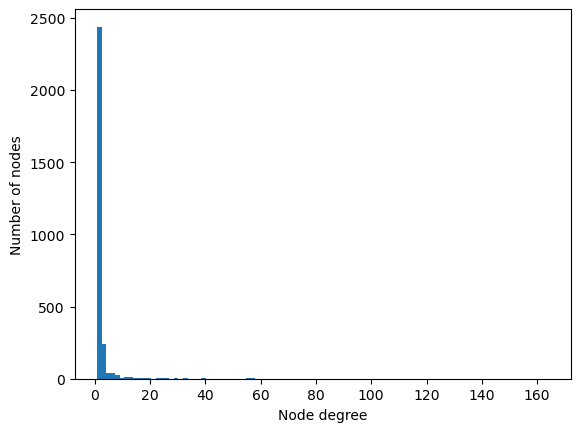

In [15]:
#plot node degree distribution
plt.hist(list(dict(G.degree).values()), bins=100)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.savefig('wikidata_node_degree.png')

In [9]:
#get nodes with highest degree and their degree
sorted(dict(G.degree).items(), key=lambda x: x[1], reverse=True)[:10]

[('computer science', 164),
 ('artificial intelligence', 120),
 ('machine learning', 103),
 ('Q114715608', 79),
 ('software engineering', 58),
 ('artificial neural network', 58),
 ('natural language processing', 57),
 ('computer graphics', 55),
 ('Q114737626', 55),
 ('cryptography', 41)]

In [10]:
#most central concepts to learn computer science
#measured in different centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

#print top 10 central nodes
print("Degree centrality")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Closeness centrality")
print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Betweenness centrality")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
print("Eigenvector centrality")
print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

Degree centrality
[('computer science', 0.05724258289703316), ('artificial intelligence', 0.041884816753926704), ('machine learning', 0.035951134380453754), ('Q114715608', 0.02757417102966841), ('software engineering', 0.02024432809773124), ('artificial neural network', 0.02024432809773124), ('natural language processing', 0.019895287958115185), ('computer graphics', 0.019197207678883072), ('Q114737626', 0.019197207678883072), ('cryptography', 0.01431064572425829)]
Closeness centrality
[('computer science', 0.24787232205259913), ('artificial intelligence', 0.09468668289937324), ('Q114737626', 0.08032157290623414), ('cognitive science', 0.06685261669217082), ('mathematics', 0.0665200940349092), ('emerging technology', 0.06604719748855516), ('reasoning', 0.06604719748855516), ('graph theory', 0.06490803436674988), ('theory of simplicial complexes', 0.05662132576158328), ('machine learning', 0.05476956307374452)]
Betweenness centrality
[('Q114737626', 0.00033124689227529325), ('artificial

In [11]:
#all paths ending with 'artificial neural network'
paths = nx.single_source_shortest_path(G.reverse(), 'artificial neural network')
for source, path in paths.items():
    path.reverse()
    print(source, path)

artificial neural network ['artificial neural network']
ADALINE ['ADALINE', 'artificial neural network']
hierarchical temporal memory ['hierarchical temporal memory', 'artificial neural network']
Neocognitron ['Neocognitron', 'artificial neural network']
autoencoder ['autoencoder', 'artificial neural network']
self-organizing map ['self-organizing map', 'artificial neural network']
Kohonen neural network ['Kohonen neural network', 'artificial neural network']
recurrent neural network ['recurrent neural network', 'artificial neural network']
quantum neural network ['quantum neural network', 'artificial neural network']
autoregressive model ['autoregressive model', 'artificial neural network']
time delay neural network ['time delay neural network', 'artificial neural network']
radial basis function network ['radial basis function network', 'artificial neural network']
modular neural network ['modular neural network', 'artificial neural network']
Optical neural network ['Optical neural ne

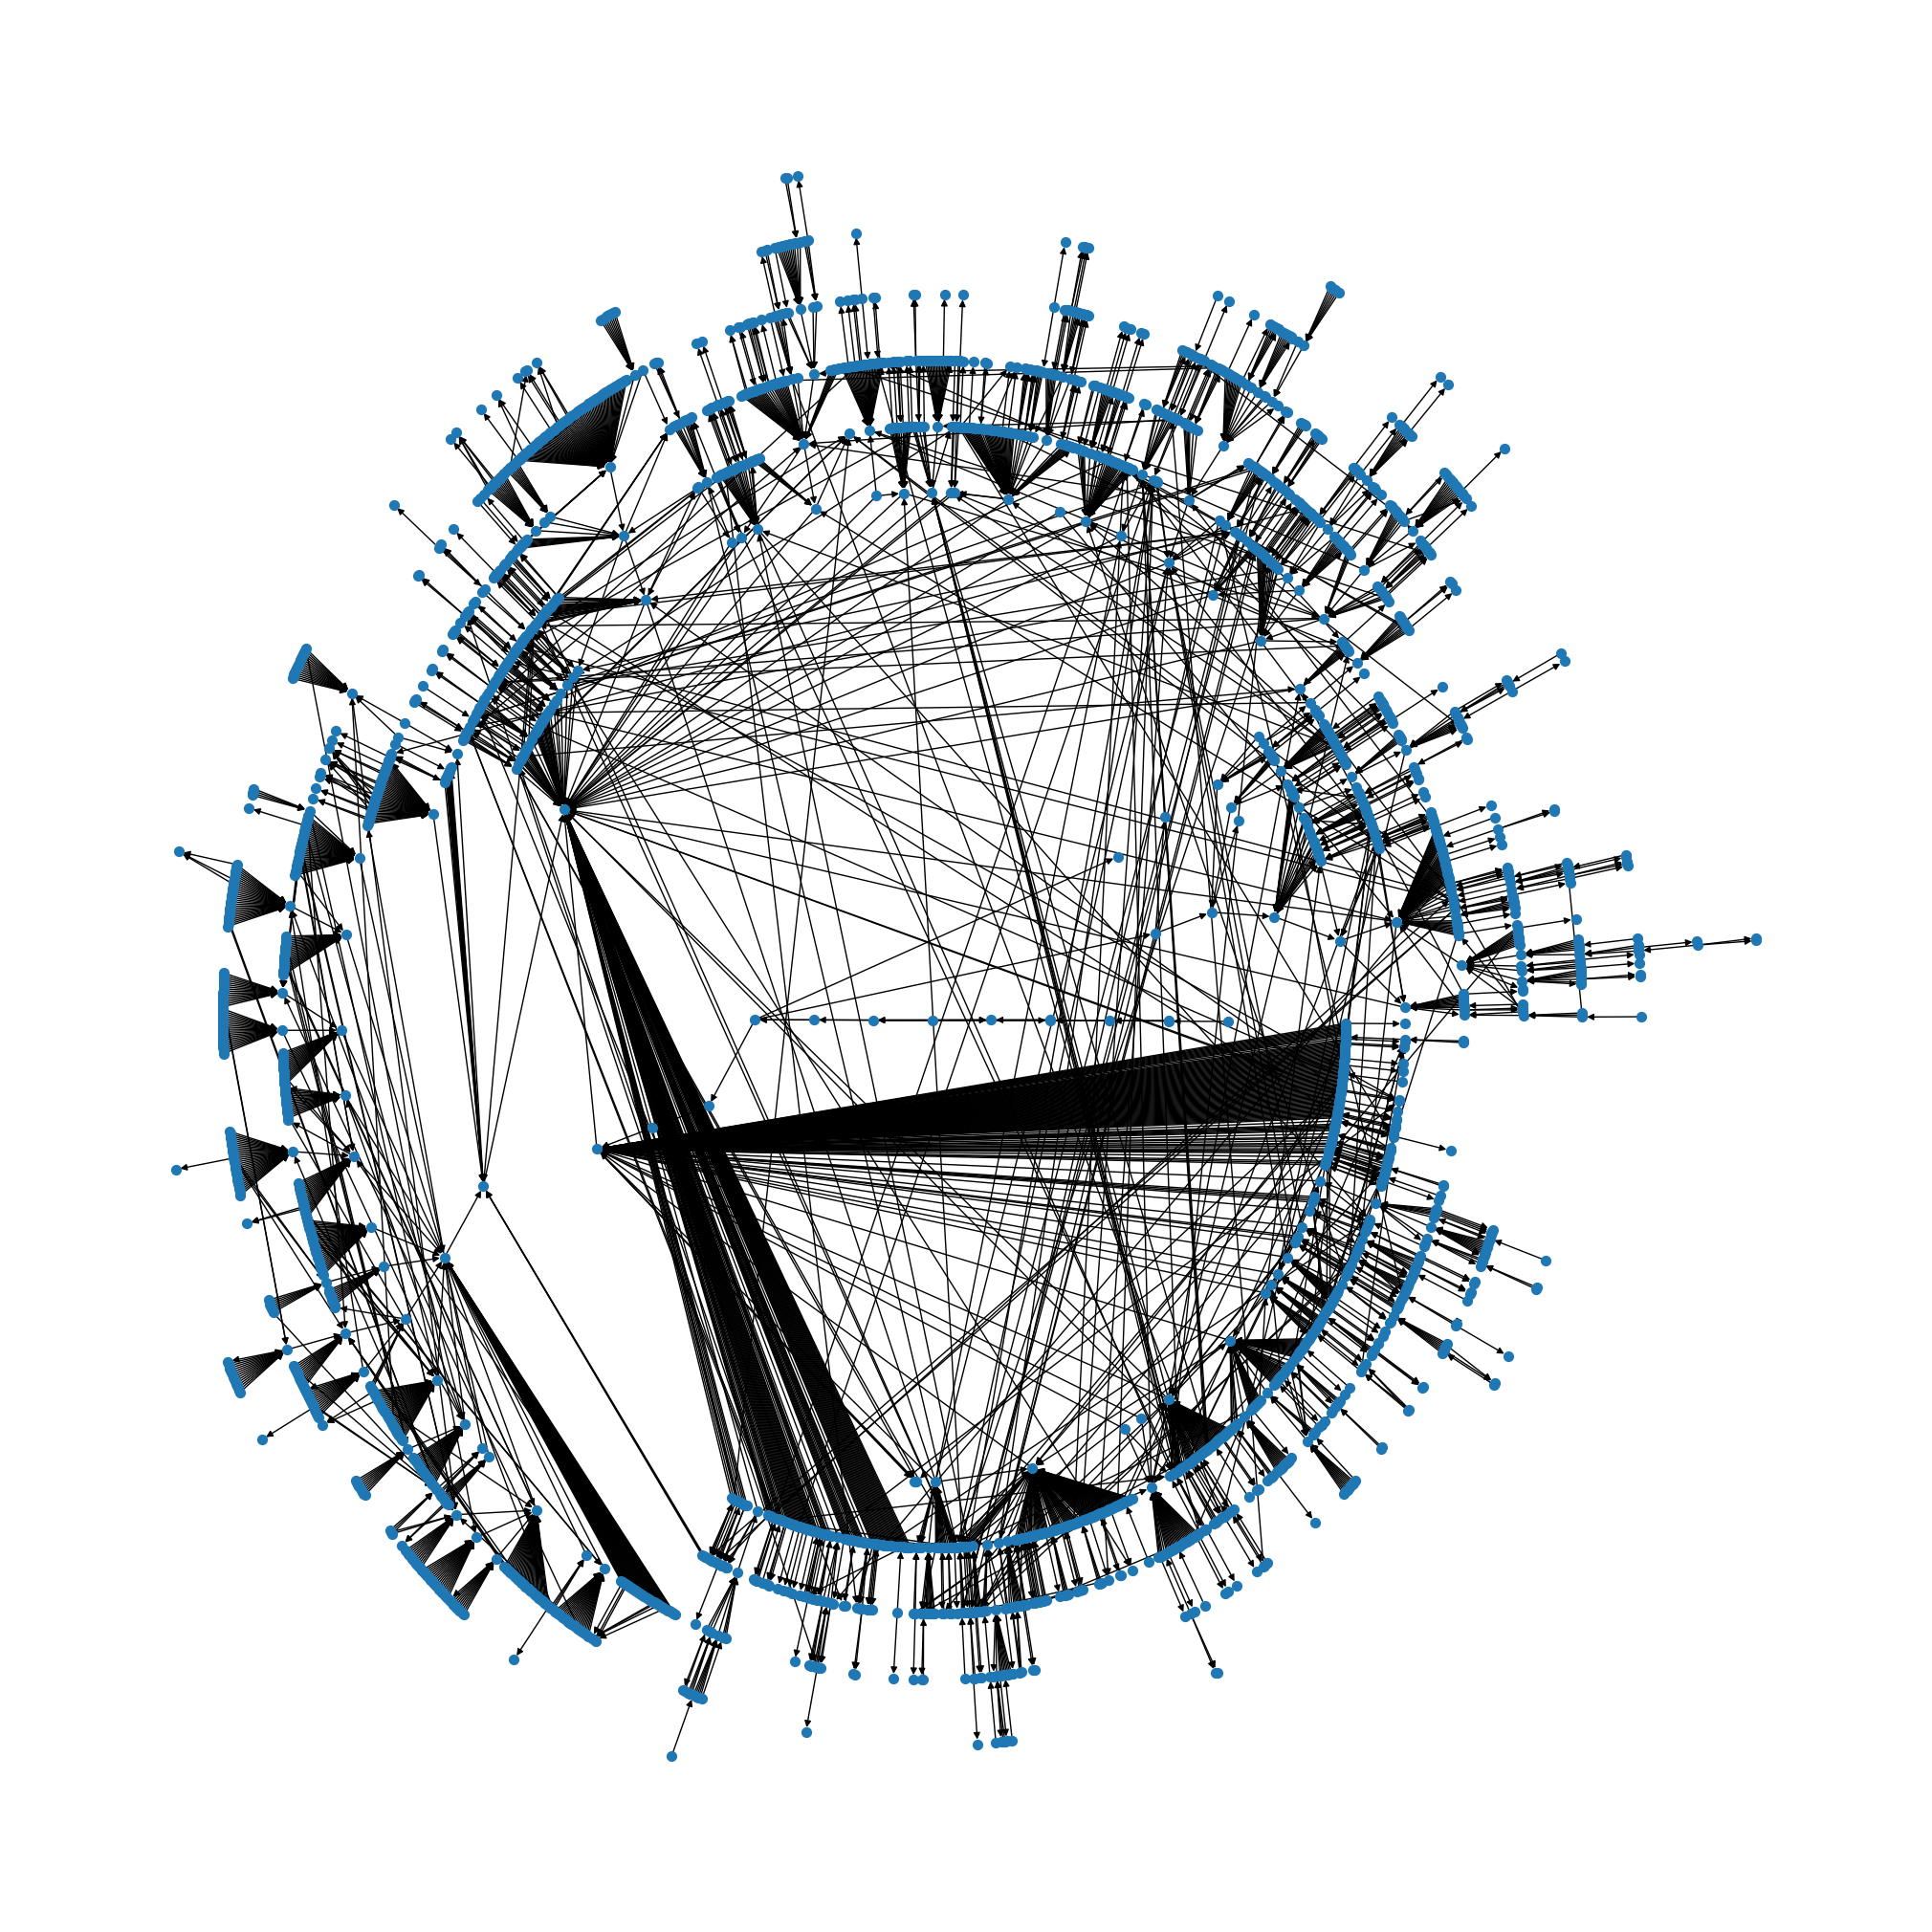

In [13]:
#Visualize the structure of graph with edges for 20 nodes
plt.figure(figsize=(20, 20))
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
nx.draw(G, pos, node_size=50)
plt.savefig('wikidata.png')

Constructing syllabuses with wikidata

In [23]:
G.nodes()

NodeView(('Open-source robotics', 'robotics', 'computational biology', 'biology', 'information science', 'computational science', 'computational chemistry', 'cheminformatics', 'theoretical and computational chemistry', 'association rule learning', 'data mining', 'nanorobotics', 'nanotechnology', 'component-based software engineering', 'computer programming', 'software engineering', 'cluster analysis', 'data analysis', 'affinity analysis', 'web mining', 'software architecture', 'systems architecture', 'human–robot interaction', 'human–computer interaction', 'computer-aided software engineering', 'computational physics', 'physics', 'Cognitive robotics', 'computational mathematics', 'mathematics', 'computational philology', 'philology', 'MICR', 'optical character recognition', 'web engineering', 'computer science', 'software reengineering', 'reengineering', 'knowledge extraction', 'Q1609335', 'computer graphics', 'telerobotics', 'model-driven engineering', 'systems engineering', 'server-b

In [38]:
# All paths leading to 'NP' 
paths = nx.single_source_shortest_path(G, 'support vector machine')
for source, path in paths.items():
    path.reverse()
    for n in path:
        print(f"{n} -> ", end="")
    print()

support vector machine -> 
supervised learning -> support vector machine -> 
classification algorithm -> support vector machine -> 
machine learning -> supervised learning -> support vector machine -> 
artificial intelligence -> machine learning -> supervised learning -> support vector machine -> 
mathematics -> machine learning -> supervised learning -> support vector machine -> 
computer science -> artificial intelligence -> machine learning -> supervised learning -> support vector machine -> 
emerging technology -> artificial intelligence -> machine learning -> supervised learning -> support vector machine -> 
reasoning -> artificial intelligence -> machine learning -> supervised learning -> support vector machine -> 
cognitive science -> artificial intelligence -> machine learning -> supervised learning -> support vector machine -> 
